In [16]:
using LightGraphs
#using GraphPlot
using SimpleWeightedGraphs
using Plots
using GraphRecipes
using Random
using KrylovKit
using LinearAlgebra
using Clustering
using Images

In [17]:
function constructEpsilon(X, epsilon)
    lines,column = size(X)
    output = zeros(Float64,size(X))
    for i = 1:lines
        for j = 1:column
            if X[i,j] > epsilon
                output[i,j] = 0
            else
                output[i,j] = X[i,j]
            end
        end
    end
    return output
end

constructEpsilon (generic function with 1 method)

In [18]:
n=25
Xb = Random.rand(1:4,n,n)

X = Xb'.*Xb
#println(X)
"""
println(S)
W = constructEpsilon(S,2)
println(W)
"""

"println(S)\nW = constructEpsilon(S,2)\nprintln(W)\n"

In [19]:
"""g = SimpleWeightedGraph(W)
println(length(g))
#print(collect(vertices(g)))
graphplot(g, curves=false)
#println(g.weights)
#gplot(g)"""

"g = SimpleWeightedGraph(W)\nprintln(length(g))\n#print(collect(vertices(g)))\ngraphplot(g, curves=false)\n#println(g.weights)\n#gplot(g)"

In [20]:
function createD(W)
    lines,column = size(W)
    output = zeros(Float64,size(W))
    for i = 1:lines
        sum = 0
        for j = 1:column
            sum += W[i,j]
        end
        output[i,i] = sum
    end
    return output
end

createD (generic function with 1 method)

In [21]:
function euclideanDistance(p,c)
    sum = 0
    for (index,coord) = enumerate(p) 
        sum += (coord-c[index])^2
    end
    return(sqrt(sum))
end

euclideanDistance (generic function with 1 method)

In [23]:
function unnormalizedSpectralClustering(X,k)
    W = constructEpsilon(X,5)
    D = createD(W)
    L = D-W
    (eigval,eigvecs,info)= eigsolve(L,k, :SR)#si plus de k valeurs ont convergées en même temps, eigval contient toutes les valeurs
    eigval = eigval[1:k]#la première valeur est très proche de 0 par rapport aux autres. On supposera donc qu'elle vaut 0
    eigvecs = eigvecs[1:k]#le premier vecteur propre devrait être rempli de 1. Ici, d'autres calculs problématiques font que ce n'est pas le cas. on ignorera cette valeur jusqu'à prouver que l'on ne peut pas l'ignorer
    U = zeros(length(eigvecs[1]))
    for v in eigvecs
        U = hcat(U,v)
    end
    U = U[1:end,2:k+1]#on enlève la première colonne qui vient de l'initialisation de la matrice U
    cluster = kmeans(U,k)
    output = zeros(size(U)[1])
    for point = 1:size(U)[1]
        yj = U[point,:]
        centerDistance = zeros(k)
        for index = 1:k
            center = cluster.centers[index,:]
            centerDistance[index] = euclideanDistance(yj,center)
            index +=1
        end
        output[point] = argmin(centerDistance)
    end
    return output,cluster.centers,W,L
end

unnormalizedSpectralClustering (generic function with 1 method)

In [24]:
@time cluster = unnormalizedSpectralClustering(X,5)
clustering=cluster[1]
W = cluster[3]
L = cluster[4]
g = SimpleWeightedGraph(W)
center = cluster[2]

  4.178782 seconds (6.68 M allocations: 354.773 MiB, 8.28% gc time, 99.64% compilation time)


25×5 Matrix{Float64}:
 0.2   0.026542    -0.0437464   0.0129462  -0.273027
 0.2   0.0216029   -0.0794369  -0.0770952  -0.176401
 0.2  -0.0265335    0.205348    0.0242632  -0.324372
 0.2  -0.17579      0.162933    0.179185    0.155256
 0.2  -0.769809     0.0395023  -0.0323059   0.240864
 0.2   0.108893     0.102925    0.119926   -0.179905
 0.2   0.0845716    0.0824414  -0.205106   -0.0413254
 0.2  -0.113511    -0.0408013   0.144493    0.0250161
 0.2  -0.00566777  -0.101006   -0.0152232   0.0842067
 0.2   0.0447772   -0.108581    0.0675416  -0.076403
 0.2   0.0654481    0.0669389  -0.0479605   0.0614477
 0.2   0.123659    -0.187853    0.0199998  -0.202989
 0.2   0.291803     0.644783    0.0780907   0.404049
 0.2  -0.308201     0.0947333   0.0985534  -0.179195
 0.2   0.056215    -0.0644071   0.143609    0.144024
 0.2   0.0773919   -0.0100909  -0.0114696  -0.0849227
 0.2   0.115364     0.0124104  -0.265616   -0.239321
 0.2   0.190505     0.215005   -0.135068    0.0075152
 0.2  -0.044961   

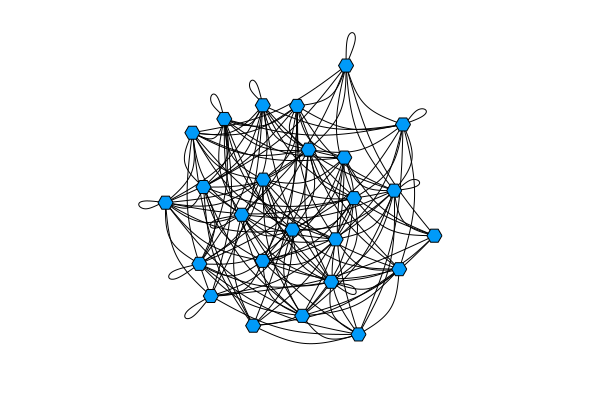

In [25]:
graphplot(g,markersize = 0.2)


In [26]:
L

25×25 Matrix{Float64}:
 43.0  -4.0  -2.0   0.0   0.0  -4.0  …  -3.0   0.0   0.0  -4.0   0.0  -2.0
 -4.0  32.0   0.0   0.0  -2.0   0.0     -3.0  -1.0  -2.0  -1.0   0.0   0.0
 -2.0   0.0  32.0  -4.0   0.0  -4.0     -3.0   0.0   0.0  -2.0   0.0   0.0
  0.0   0.0  -4.0  34.0  -3.0   0.0      0.0   0.0  -2.0   0.0  -4.0  -1.0
  0.0  -2.0   0.0  -3.0  24.0   0.0      0.0   0.0  -3.0  -3.0  -3.0   0.0
 -4.0   0.0  -4.0   0.0   0.0  36.0  …   0.0   0.0  -4.0   0.0  -4.0   0.0
 -2.0  -4.0   0.0   0.0   0.0   0.0     -3.0   0.0   0.0   0.0   0.0  -1.0
 -3.0   0.0  -1.0  -3.0  -3.0  -3.0     -4.0  -2.0   0.0   0.0  -2.0  -2.0
  0.0  -4.0  -1.0  -4.0   0.0   0.0     -4.0  -2.0   0.0  -3.0  -4.0  -2.0
 -4.0  -3.0   0.0  -2.0   0.0  -4.0     -4.0  -2.0  -4.0  -2.0  -2.0  -1.0
  0.0  -2.0  -4.0  -3.0   0.0  -3.0  …  -2.0  -2.0  -1.0  -1.0  -3.0  -2.0
 -4.0  -2.0   0.0   0.0   0.0  -4.0     -4.0  -2.0  -2.0  -4.0  -2.0  -4.0
 -1.0   0.0   0.0  -3.0   0.0  -3.0      0.0   0.0   0.0   0.0  -3.0   0.0
 -

In [27]:
W

25×25 Matrix{Float64}:
 0.0  4.0  2.0  0.0  0.0  4.0  2.0  3.0  …  0.0  3.0  0.0  0.0  4.0  0.0  2.0
 4.0  0.0  0.0  0.0  2.0  0.0  4.0  0.0     0.0  3.0  1.0  2.0  1.0  0.0  0.0
 2.0  0.0  1.0  4.0  0.0  4.0  0.0  1.0     0.0  3.0  0.0  0.0  2.0  0.0  0.0
 0.0  0.0  4.0  0.0  3.0  0.0  0.0  3.0     0.0  0.0  0.0  2.0  0.0  4.0  1.0
 0.0  2.0  0.0  3.0  0.0  0.0  0.0  3.0     3.0  0.0  0.0  3.0  3.0  3.0  0.0
 4.0  0.0  4.0  0.0  0.0  0.0  0.0  3.0  …  0.0  0.0  0.0  4.0  0.0  4.0  0.0
 2.0  4.0  0.0  0.0  0.0  0.0  0.0  1.0     3.0  3.0  0.0  0.0  0.0  0.0  1.0
 3.0  0.0  1.0  3.0  3.0  3.0  1.0  0.0     0.0  4.0  2.0  0.0  0.0  2.0  2.0
 0.0  4.0  1.0  4.0  0.0  0.0  1.0  2.0     3.0  4.0  2.0  0.0  3.0  4.0  2.0
 4.0  3.0  0.0  2.0  0.0  4.0  0.0  3.0     2.0  4.0  2.0  4.0  2.0  2.0  1.0
 0.0  2.0  4.0  3.0  0.0  3.0  3.0  3.0  …  4.0  2.0  2.0  1.0  1.0  3.0  2.0
 4.0  2.0  0.0  0.0  0.0  4.0  2.0  0.0     0.0  4.0  2.0  2.0  4.0  2.0  4.0
 1.0  0.0  0.0  3.0  0.0  3.0  4.0  0.0  

In [28]:
output = zeros(size(center)[2],size(W)[2])
for i in range(1,size(center)[2],step=1)
    for j in range(1,size(L)[2],step=1)
        output[i,j] = euclideanDistance(L[:,j],center[:,i])
    end
end
output

5×25 Matrix{Float64}:
 44.6654  33.4515  33.6601  35.5387  …  36.5103  39.5601  44.6206  26.1343
 44.6532  33.4382  33.6762  35.6401     36.5183  39.6251  44.6303  25.9977
 44.6866  33.5027  33.528   35.4395     36.5933  39.5741  44.5807  26.5579
 44.6588  33.5041  33.6436  35.4233     36.3906  39.5408  44.5622  26.154
 44.8142  33.5798  33.8942  35.432      36.4852  39.7023  44.5842  25.8338

In [29]:
### version k means

In [32]:
@time km = kmeans(X,5)
kcenters = km.centers

  0.000393 seconds (30 allocations: 6.094 KiB)


25×5 Matrix{Float64}:
  5.22222   5.28571   9.0   5.4  12.0
  5.33333   8.14286   3.0   9.0   3.33333
  6.22222   5.0       4.0  11.0   2.33333
  6.77778   5.57143  12.0   4.8   5.0
  7.0       7.14286   8.0   9.2   8.66667
  5.66667   9.71429   1.0   8.2   4.33333
  5.77778   8.42857  16.0   3.6   2.0
  6.77778   4.85714  12.0   6.6   2.66667
  3.77778   4.85714   9.0   6.0   6.66667
  3.11111   5.71429  16.0   7.4   4.33333
  3.66667   5.28571  16.0   2.6   9.66667
  4.44444   6.0      16.0   6.6   5.66667
  8.33333   9.85714   4.0   6.2   4.0
  7.55556   6.57143   6.0   7.6   7.33333
  3.77778   8.14286   6.0   9.4   7.0
  4.11111   6.85714   4.0   7.0   3.0
 12.0       5.42857   4.0   2.4   7.0
  7.77778   3.85714  16.0   9.0  11.3333
  5.0       9.42857   3.0   6.6   4.33333
  5.88889   9.0       9.0   3.4   3.0
  6.0       9.57143   3.0   3.4   6.66667
  9.22222   4.57143   2.0   2.8   7.0
  8.0       6.42857   1.0   3.2   2.66667
  6.11111   5.28571   3.0   4.0   5.0
  4.44444  

In [33]:
output = zeros(size(center)[2],size(X)[2])
for i in range(1,size(center)[2],step=1)
    for j in range(1,size(X)[2],step=1)
        output[i,j] = euclideanDistance(X[:,j],kcenters[:,i])
    end
end
output

5×25 Matrix{Float64}:
 24.8636  28.9382  25.7612  18.4535  …  18.4505  21.9387  15.2161  19.0023
 25.6611  26.0122  19.5318  22.3429     25.9654  15.1442  20.762   23.9566
 34.0881  41.9881  33.9853  31.607      38.5746  34.7275  36.7151  41.7373
 26.6045  20.3568  23.7318  24.7063     28.7993  25.5225  21.6194  24.3023
 15.337   32.968   28.8251  21.8835     24.9511  28.7846  20.1301  26.5183

In [10]:
E = [1 2; 2 1]
F = [4 0 ; 0 3]
F^-1*E
F^-1/2*E*F^-1/2

2×2 Matrix{Float64}:
 0.015625   0.0416667
 0.0416667  0.0277778